In [1]:
# Visualization of acoustic field and directivity plots

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import numpy as np
import h5py
from collections import defaultdict
from tqdm import tqdm

from scipy.spatial import Delaunay

Matplotlib is building the font cache; this may take a moment.


In [39]:
class base(object):
    
    def __init__(self):
        start  = 100  #60
        end    = 160.2   #90
        dt     = 0.1     #0.1

        tt = np.arange(start, end, dt)
        self.time = list()
        for i in range(len(tt)):
            self.time.append("{:.2f}".format(tt[i]))
        
        
    
    def read_files(self, name):
        soln = defaultdict()
        f = h5py.File(name,'r')
        for key in f:
            soln[key] = np.array(f[key])

        return soln
    
    def time_averaged(self):
    

        avg_soln = defaultdict()
        for tt in tqdm(self.time):
            name = f'./time_series_{tt}.zhenyang'
            soln = self.read_files(name)

            if tt == self.time[0]:
                for key in soln:
                    avg_soln[key] = soln[key][:,:5]
            else:
                for key in soln:
                    avg_soln[key] += soln[key][:,:5]

        for key in soln:
            avg_soln[key] = avg_soln[key] / len(self.time) 

        return avg_soln
    
    def fluc_fun(self, avg):
        fluc_soln = defaultdict()
        
        for tt in tqdm(self.time):
            name = f'./time_series_{tt}.zhenyang'
            soln = read_files(name)
            
            if tt == self.time[0]:
                for key in soln:
                    fluc_soln[key] = soln[key][:,:5] - avg[key]
            else:
                for key in soln:
                    fluc_soln[key] = np.dstack((fluc_soln[key],soln[key][:,:5] - avg[key]))
                
                #print(fluc_soln[key].shape)
                
            
        return fluc_soln

avg_soln = base().time_averaged()
fluc_soln = base().fluc_fun(avg_soln)

100%|██████████| 602/602 [21:36<00:00,  2.15s/it]


In [40]:
fluc_soln['hex_p0'].shape

(64050, 5, 602)

(262380, 5)


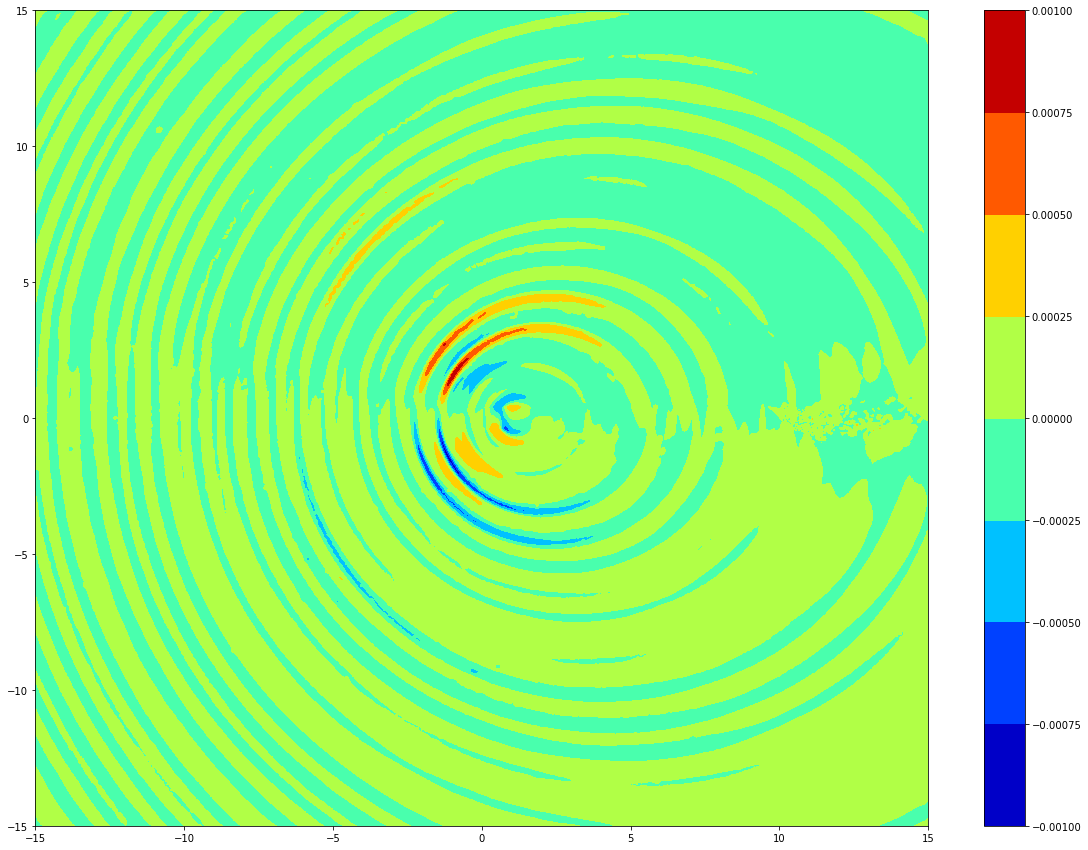

In [65]:
class visualization(base):
    def __init__(self):
        super().__init__()
        
        #avg_soln = self.time_averaged()
        #fluc_soln = self.fluc_fun(avg_soln)
        name = f'./time_series_100.00_mesh.zhenyang'
        
        mesh = self.read_files(name)
        
        
        temp_plot_mesh = [mesh[key][:,:2] for key in mesh.keys() if key.split('_')[0] == 'tet']
        temp_plot_soln = [fluc_soln[key][:,:5,-1] for key in fluc_soln.keys() if key.split('_')[0] == 'tet']
        
        mesh_plot = temp_plot_mesh[0]
        soln_plot = temp_plot_soln[0]
        for i in range(1,len(temp_plot_mesh)):
            mesh_plot = np.append(mesh_plot,temp_plot_mesh[i], axis = 0)
            soln_plot = np.append(soln_plot,temp_plot_soln[i], axis = 0)
            
        print(soln_plot.shape)
        plt.figure(figsize=(20, 15))
        triangle = tri.Triangulation(mesh_plot[:,0],mesh_plot[:,1])
        plt.tricontourf(triangle, soln_plot[:,-1],cmap = 'jet')
        #plt.clim(-0.001,0.001)
        cbar = plt.colorbar()
        
        
        #plt.xlim([-5,5])
        #plt.ylim([-5,5])
        
visualization()        

In [228]:
# save some time
_fluc_p = [fluc_soln[key][:,4] for key in fluc_soln.keys()]
fluc_p = _fluc_p[0]
for i in range(1,len(_fluc_p)):
    fluc_p = np.append(fluc_p,_fluc_p[i], axis = 0)

0.9977413336583252
(757580, 2) [[9.99100144e-01 1.96415218e-04]]


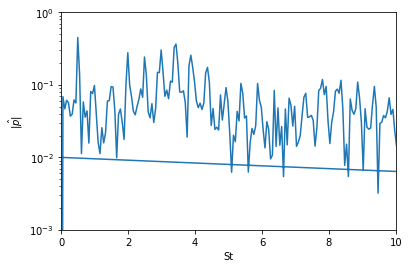

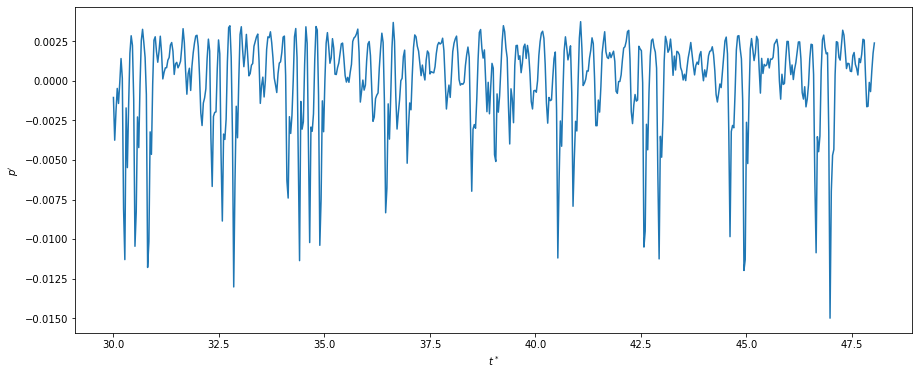

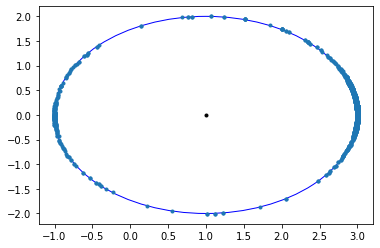

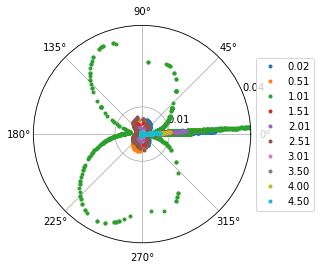

In [298]:
from math import pi
class Directivity(base):
    def __init__(self):
        super().__init__()
        
        name = f'./time_series_100.00_mesh.zhenyang'
        
        _mesh = self.read_files(name)
        self.r = 2
        
        # flatten mesh, soln pts
        # only fluctuation pressure field is considered
        _mesh = [_mesh[key][:,:2] for key in _mesh.keys()]
        _fluc_p = [fluc_soln[key][:,4] for key in fluc_soln.keys()]
        
        self.mesh = _mesh[0]
        self.fluc_p = _fluc_p[0]
        for i in range(1,len(_fluc_p)):
            self.mesh = np.append(self.mesh,_mesh[i], axis = 0)
            #self.fluc_p = np.append(self.fluc_p,_fluc_p[i], axis = 0)
        # temp
        self.fluc_p = fluc_p
            
            
    def directivity(self):
        
        index0 = np.where(abs(self.get_trailing_edge_pt() - self.mesh[:,0]) < 10e-7)[0]

        # trailing pt
        fluc_p_h = np.fft.fft(self.fluc_p[index0])
        freq = np.fft.fftfreq(len(self.time), d=0.1)
        plt.figure()
        plt.plot(freq*1/0.3,abs(fluc_p_h).T)
        plt.yscale('log')
        plt.xlim([0,10])
        plt.ylim([10e-4,10e-1])
        plt.xlabel('St')
        plt.ylabel('$\hat{|p|}$')
        
       
        
        # pressure fluctuation signal at trailing edge
        plt.figure(figsize=(15,6))
        plt.plot(np.arange(100,160.2,0.1)*0.3/1,self.fluc_p[index0].T)
        plt.xlabel('$t^*$')
        plt.ylabel('$p\'$')
        
        
        # directivity
        mesh_aoa = self.rotate(self.mesh,pi/60)
        
        base_pt = mesh_aoa[index0]
            
        dist = mesh_aoa - base_pt
        print(dist.shape,base_pt)
        dist = np.sqrt(dist[:,0]**2 + dist[:,1]**2)
        index = np.where(abs(dist - self.r) < 10e-3)[0]
        
        
        plt.figure()
        plt.plot(mesh_aoa[index,0],mesh_aoa[index,1],'.')
        plt.plot(base_pt[:,0],base_pt[:,1],'k.')
        circle1 = plt.Circle((base_pt[:,0],base_pt[:,1]),self.r, color='b', fill=False)
        plt.gca().add_patch(circle1)
        
        
        fluc_p_h = np.fft.fft(self.fluc_p[index], axis=-1)
        
        theta, r = self.polar_coor(mesh_aoa[index,0],mesh_aoa[index,1])
        
        plt.figure()
        for i in range(1, fluc_p_h.shape[1],30):
            if freq[i] > 0:
                plt.polar(theta,abs(fluc_p_h[:,i]),'.',label="{:.2f}".format(freq[i]))
        plt.ylim([0,0.04])
        plt.yticks([0.01, 0.04])  # Less radial ticks
        plt.grid(True)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


    def polar_coor(self, x, y):
        theta =np.arctan2(y,x)
        r = np.sqrt(x**2+y**2)
        return theta,r

    # rotation routine
    def rotate(self, mesh, deg):
        mesh_aoa = np.zeros_like(mesh)
        mesh_aoa[:,0] = mesh[:,0]*np.cos(deg) - mesh[:,1]*np.sin(deg)
        mesh_aoa[:,1] = mesh[:,0]*np.sin(deg) + mesh[:,1]*np.cos(deg)
        
        
        return mesh_aoa
        
        
        
    def fft(self, var):
        return np.fft.fft(var)
        
        
    def get_trailing_edge_pt(self):
        # First, we have get aerofoil points, which is exist in the boundary extraction but since it is written months ago 
        # and very inefficient, here rewrite it in the class bc_extract
        
        # Get trailing edge point
        bc_coord = bc_extract().extract_bc()
        max_x = 0
        for key in bc_coord:
            if np.max(bc_coord[key][...,0]) > max_x:
                max_x = np.max(bc_coord[key][...,0])
                
        print(max_x)
        return max_x
            
Directivity().directivity()

In [165]:
from pyfr.readers.native import NativeReader
from pyfr.util import subclass_where
class bc_extract(object):
    
    def __init__(self):
        name = f'../mesh.pyfrm'
        
        self.mesh = NativeReader(name)
        self.mesh_inf = self.mesh.array_info('spt')
        self.bc_inf = self.mesh.array_info('bcon')
            
        self.suffix = ['wall']
        
        self.order = 4
        self.ndim = next(iter(self.mesh_inf.values()))[1][2]
        
        
    def extract_bc(self):
        bc_eid = defaultdict(list)
        bc_fid = defaultdict(list)
        
        for key in self.bc_inf:
            if key.split('_')[1] in self.suffix:
                part = key.split('_')[-1]
                
                for etype, eid, fid, pid in self.mesh[key].astype('U4,i4,i1,i2'):
                    bc_eid[f'{etype}_{part}'].append(eid)
                    bc_fid[f'{etype}_{part}'].append(fid)
                bc_fid[f'{etype}_{part}'] = np.array(bc_fid[f'{etype}_{part}'],dtype = np.int8)  
                
        
        
        fmap = self.facemap('hex')
        bc_coord = defaultdict()
        
        for key in self.mesh_inf:
            prefix, etype, part = key.split('_')
            name = f'{etype}_{part}'
            
            if name in bc_eid:
                """bug here fix it by convert it to normal vector?"""
                a = fmap[bc_fid[name][0]]
                bc_coord[name] = self.mesh[key][:,bc_eid[name]]
                bc_coord[name] = bc_coord[name][a]
        
        return bc_coord
    
    def facemap(self, etype):
        from pyfr.shapes import BaseShape
        shapecls = subclass_where(BaseShape, name=etype)
        
        std_ele = np.array(shapecls.std_ele(self.order))
        
        fmap = list()
        
        a = np.array([-1,1])
        for i in range(self.ndim):
            for j in a:
                fmap.append(np.where(std_ele[:,i] == j)[0])
        
        """Bug here !!!!! fix it by sorting out which is fid == 1"""
        index = np.array([1,2])
        
        return np.array(fmap)[index]
        
        
bc_coord = bc_extract().extract_bc()

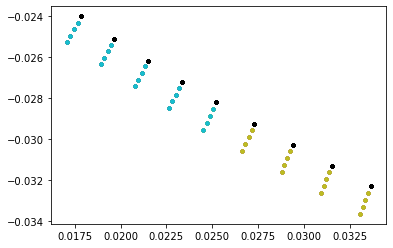

In [166]:
plt.plot(temp['hex_p1'][:,:10,0],temp['hex_p1'][:,:10,1],'.')
plt.plot(bc_coord['hex_p1'][:,:10,0],bc_coord['hex_p1'][:,:10,1],'k.')
